In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# !pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 13.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno

from tqdm.notebook import tqdm
from math import sqrt

from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, roc_curve, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import Lasso,Ridge
from sklearn.pipeline import Pipeline

import lightgbm as lgbm
from xgboost import XGBClassifier

# from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial #함수 고정

### 데이터 프레임 준비

모델링 할시 필요한 변수 그리고 optimal threshold를 계산하기 위한 변수들만 불려온다

In [ ]:
def make_df(df_path, variables_path):
    df = pd.read_pickle(df_path)
    variables = pd.read_csv(variables_path)
    
    target_col = "depvar"
    target_df = df[target_col]
    use_col = variables.loc[variables["use_or_not"] == "use" , "columns"]
    cal_col = variables.loc[variables["use_or_not"] == "cal" , "columns"]
    use_df = df[list(use_col) + list(cal_col)]
    print("-"*20, "사용 변수 출력", "-"*20)
    for col in use_col:
        print(f"{col}: [{df.dtypes[col]} ,{len(df[col].unique())}]")
        print(list(variables.loc[variables["columns"]==col, "explain"])[0])
        print("-"*50)
    return use_df, target_df, use_col, cal_col

In [ ]:
df_path = "/content/drive/MyDrive/함께하조/data/datacompression_lendingclub.pkl"
test_path = "/content/drive/MyDrive/함께하조/data/compression_lendingclub_test.pkl"
variables_path = "/content/drive/MyDrive/함께하조/data/variables_final.csv"

use_df, target_df, use_col, cal_col = make_df(df_path, variables_path)

-------------------- 사용 변수 출력 --------------------
loan_amnt: [int32 ,1508]
신청자가 신청한 대출 금액을 의미합니다. 만약 대출 심사 과정에서 대출 금액이 줄어들면, 이 값이 해당 금액으로 반영됩니다.
--------------------------------------------------
annual_inc: [float64 ,48059]
등록 시 대출자가 제공한 자테 보고 연간소득
--------------------------------------------------
dti: [float64 ,4726]
모기지 및 요청된 LC대출을 제외한 총 부체에 대한 차용인의 월별 부채 총액을 차용인의 자체 보고 월 소득으로 나누어 계산한 비율
--------------------------------------------------
delinq_2yrs: [int8 ,26]
지난 2년간 대출자의 신용 파일에서 연체된 30일 이상의 건수
--------------------------------------------------
fico_range_low: [int16 ,38]
대출 발행 시점에 차용인의 Fico(신용점수)가 속하는 하한 범위 (min: 660, fair / max: 845, excellent)
--------------------------------------------------
fico_range_high: [int16 ,38]
대출 발행 시점에 차용인의 Fico(신용점수)가 속하는 상한 범위 (min: 664, fair / max: 850, excellent)
--------------------------------------------------
inq_last_6mths: [int8 ,9]
최근 6개월간 조회(inquiry)건수(자동차 및 주택담보대출 조회 제외). inquiry는 돈을 빌리거나 할 때 이루어진다. hard inquiry는 신용등급에 영향을 주며 2년간 기록이 

In [ ]:
test_use_df, test_target_df, use_col, cal_col = make_df(test_path, variables_path)

-------------------- 사용 변수 출력 --------------------
loan_amnt: [int32 ,1417]
신청자가 신청한 대출 금액을 의미합니다. 만약 대출 심사 과정에서 대출 금액이 줄어들면, 이 값이 해당 금액으로 반영됩니다.
--------------------------------------------------
annual_inc: [float64 ,16396]
등록 시 대출자가 제공한 자테 보고 연간소득
--------------------------------------------------
dti: [float64 ,4325]
모기지 및 요청된 LC대출을 제외한 총 부체에 대한 차용인의 월별 부채 총액을 차용인의 자체 보고 월 소득으로 나누어 계산한 비율
--------------------------------------------------
delinq_2yrs: [int8 ,21]
지난 2년간 대출자의 신용 파일에서 연체된 30일 이상의 건수
--------------------------------------------------
fico_range_low: [int16 ,38]
대출 발행 시점에 차용인의 Fico(신용점수)가 속하는 하한 범위 (min: 660, fair / max: 845, excellent)
--------------------------------------------------
fico_range_high: [int16 ,38]
대출 발행 시점에 차용인의 Fico(신용점수)가 속하는 상한 범위 (min: 664, fair / max: 850, excellent)
--------------------------------------------------
inq_last_6mths: [int8 ,7]
최근 6개월간 조회(inquiry)건수(자동차 및 주택담보대출 조회 제외). inquiry는 돈을 빌리거나 할 때 이루어진다. hard inquiry는 신용등급에 영향을 주며 2년간 기록이 

카테고리: home_ownership, verfification_status, purpose

In [ ]:
## fico average column 생성, column drop
use_df["fico_average"] = (use_df["fico_range_high"] + use_df["fico_range_low"])/2
use_df.drop(["fico_range_high", "fico_range_low"], axis=1, inplace=True)

test_use_df["fico_average"] = (test_use_df["fico_range_high"] + test_use_df["fico_range_low"])/2
test_use_df.drop(["fico_range_high", "fico_range_low"], axis=1, inplace=True)

In [ ]:
# last fico에 대한 last_fico_range_big 이라는 컬럼 생성
use_df.loc[(use_df["last_fico_range_high"] - use_df["last_fico_range_low"])==499, "last_fico_range_big"] = 1
use_df.loc[(use_df["last_fico_range_high"] - use_df["last_fico_range_low"])!=499, "last_fico_range_big"] = 0

test_use_df.loc[(test_use_df["last_fico_range_high"] - test_use_df["last_fico_range_low"])==499, "last_fico_range_big"] = 1
test_use_df.loc[(test_use_df["last_fico_range_high"] - test_use_df["last_fico_range_low"])!=499, "last_fico_range_big"] = 0

In [ ]:
#카테고리 피쳐 변환
categorical_feats = ["home_ownership", "verification_status", "purpose", "last_fico_range_big"]

for c in categorical_feats:
    use_df[c] = use_df[c].astype('category')
    test_use_df[c] = test_use_df[c].astype('category')

In [ ]:
## emp_length 변경
length = [[1, 1], [2, 10], [3, 2], [4, 3], [5, 4], [6, 5], [7, 6], [8, 7], [9, 8], [10, 9], [11, 0], [12, np.nan]]
use_df["new_emp_length"] = np.nan*use_df.shape[0]
test_use_df["new_emp_length"] = np.nan*test_use_df.shape[0]

for i in length:
    num, value = i[0], i[1]
    use_df.loc[use_df["emp_length"]==num, "new_emp_length"] = value
    test_use_df.loc[test_use_df["emp_length"]==num, "new_emp_length"] = value
    print(num, value)
    print(use_df["new_emp_length"].value_counts())
    print("-"*40)

use_df.drop(["emp_length"], axis=1, inplace=True)
test_use_df.drop(["emp_length"], axis=1, inplace=True)

1 1
1.0    57342
Name: new_emp_length, dtype: int64
----------------------------------------
2 10
10.0    288553
1.0      57342
Name: new_emp_length, dtype: int64
----------------------------------------
3 2
10.0    288553
2.0      78893
1.0      57342
Name: new_emp_length, dtype: int64
----------------------------------------
4 3
10.0    288553
2.0      78893
3.0      69896
1.0      57342
Name: new_emp_length, dtype: int64
----------------------------------------
5 4
10.0    288553
2.0      78893
3.0      69896
1.0      57342
4.0      50974
Name: new_emp_length, dtype: int64
----------------------------------------
6 5
10.0    288553
2.0      78893
3.0      69896
1.0      57342
5.0      53590
4.0      50974
Name: new_emp_length, dtype: int64
----------------------------------------
7 6
10.0    288553
2.0      78893
3.0      69896
1.0      57342
5.0      53590
4.0      50974
6.0      40619
Name: new_emp_length, dtype: int64
----------------------------------------
8 7
10.0    288553
2.

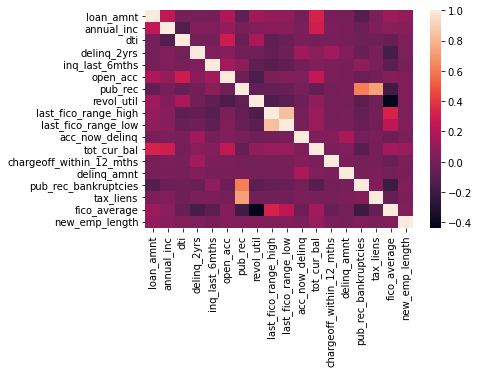

In [ ]:
# colleration 재확인
sns.heatmap(use_df.drop(cal_col, axis=1).corr());

In [ ]:
#새로 만든 변수 확인
set(use_df.drop(cal_col, axis=1).columns) - set(use_col)

{'fico_average', 'last_fico_range_big', 'new_emp_length'}

In [ ]:
#삭제변수 확인
set(use_col) - set(use_df.drop(cal_col, axis=1).columns)

{'emp_length', 'fico_range_high', 'fico_range_low'}

In [ ]:
use_df.drop(cal_col, axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874335 entries, 0 to 874334
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   loan_amnt                 874335 non-null  int32   
 1   annual_inc                874335 non-null  float64 
 2   dti                       874335 non-null  float64 
 3   delinq_2yrs               874335 non-null  int8    
 4   inq_last_6mths            874335 non-null  int8    
 5   open_acc                  874335 non-null  int16   
 6   pub_rec                   874335 non-null  int8    
 7   revol_util                874335 non-null  float64 
 8   last_fico_range_high      874335 non-null  int16   
 9   last_fico_range_low       874335 non-null  int16   
 10  acc_now_delinq            874335 non-null  int8    
 11  tot_cur_bal               874335 non-null  int32   
 12  chargeoff_within_12_mths  874335 non-null  int8    
 13  delinq_amnt               874

### 데이터 준비(train, test split)

In [ ]:
def train_test(use_df, target_df, test_size=0.2, random_state=2023):
    x_train, x_test, y_train, y_test = train_test_split(use_df, target_df, test_size=test_size, random_state=random_state, stratify=target_df) #shuffle false라고 생각했는데 shuffle True라고 했을때 random state를 설정하는 의미가 있다고 나옴

    # k-fold 사용해주기 위해서 (x_train, y_train) index 다시 설정
    x_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    #test_size 확인
    print(f"test_size: {x_test.shape[0]/use_df.shape[0]*100}%")

    #shape 확인
    print("x_train.shape: ", x_train.shape)
    print("x_test.shape: ", x_test.shape)
    print("y_train.shape: ", y_train.shape)
    print("y_test.shape: ", y_test.shape)

    #train, test 클래스 비율 확인
    print(f"train positive 비율: {pd.Series(y_train).value_counts()[1]/len(pd.Series(y_train))}")
    print(f"test positive 비율: {pd.Series(y_test).value_counts()[1]/len(pd.Series(y_test))}")

    return x_train, x_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test(use_df, target_df, test_size=0.2, random_state=2023)

test_size: 20.0%
x_train.shape:  (699468, 27)
x_test.shape:  (174867, 27)
y_train.shape:  (699468,)
y_test.shape:  (174867,)
train positive 비율: 0.16204601211206232
test positive 비율: 0.16204887142799956


In [ ]:
x_train = X_train.drop(cal_col, axis=1)
x_test = X_test.drop(cal_col, axis=1)

### 베이지안 최적화 & 5-Fold

In [ ]:
def new_conf(y, y_pred):
    real_pos_portion = confusion_matrix(y, y_pred)[0]/sum(confusion_matrix(y, y_pred)[0])
    real_neg_portion = confusion_matrix(y, y_pred)[1]/sum(confusion_matrix(y, y_pred)[1])
    return np.array([real_pos_portion, real_neg_portion])

def draw_cfmatrix(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    group_names = ["Fullfill -> Fullfill", "Fullfill -> Charge off", "Charge off -> Fullfill", "Charge off -> Charge off"]
    group_counts = ["count: {0:0.0f}".format(value) for value in cf_matrix.flatten()]

    #여기서 새로운 cf matrix 적용
    cf_matrix = new_conf(y, y_pred)
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    ax.set(xlabel="predict class", ylabel="real class") 
    plt.show()

def plot_roc(y, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba) 
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(y, y_pred_proba),3)),fontsize=16)
    plt.legend()
    plt.show()

def get_clf_eval(y , y_pred, y_pred_proba=None):
    confusion = confusion_matrix( y, y_pred)
    accuracy = accuracy_score(y , y_pred)
    precision = precision_score(y , y_pred)
    recall = recall_score(y , y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)

    print('오차 행렬')
    draw_cfmatrix(y , y_pred)
    print("ROC Curve")
    plot_roc(y, y_pred_proba)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, roc_auc: {3:.4f}, f1: {4:.4f},'.format(accuracy , precision ,recall, roc_auc, f1))

In [ ]:
def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha, reg_lambda, x_data=None, y_data=None, n_splits=5, random_state=2023):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    score = 0

    #local_train, local_valid를 5번 만들어서 수행
    for train_index, valid_index in kf.split(X=x_data, y=y_data):
        x_train, y_train = x_data.iloc[train_index], y_data[train_index]
        x_valid, y_valid = x_data.iloc[valid_index], y_data[valid_index]
        
        model = lgbm.LGBMClassifier(
            num_leaves = int(num_leaves), 
            learning_rate = learning_rate,
            n_estimators = int(n_estimators), 
            subsample = np.clip(subsample, 0, 1), 
            colsample_bytree = np.clip(colsample_bytree, 0, 1), 
            reg_alpha = reg_alpha, 
            reg_lambda = reg_lambda,
            objective = "binary",
        )
        
        model.fit(x_train, y_train,
                  eval_set=[(x_valid, y_valid)],
                  early_stopping_rounds=50,
                  verbose = 100, 
                  eval_metric='auc')

        
        pred = model.predict_proba(x_valid)[:, 1]
        true = y_valid
        score += roc_auc_score(true, pred)/n_splits
    
    return score

In [ ]:
import time

# 모델과 관련없는 변수 고정
func_fixed = partial(lgb_cv, x_data=x_train, y_data=y_train, n_splits=5, random_state=2023)

# 베이지안 최적화 범위 설정
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (25, 45),        # num_leaves,
        'learning_rate': (0.01, 0.1),  # learning_rate,  
        'n_estimators': (100, 1000),      # n_estimators,     
        'subsample': (0.3, 0.7),             # subsample,       
        'colsample_bytree': (0.3, 0.7),      # colsample_bytree
        'reg_alpha': (0, 0.1),            # reg_alpha,       
        'reg_lambda': (0, 0.1),           # reg_lambda,       
    }, 
    random_state=2023                 # 시드 고정
)

start_time=time.time()
lgbBO.maximize(init_points=5, n_iter=30) # 처음 5회 랜덤 값으로 score 계산 후 30회 최적화
print("---%s seconds ---" % (time.time() - start_time))

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's binary_logloss: 0.240682	valid_0's auc: 0.927434
[200]	valid_0's binary_logloss: 0.240313	valid_0's auc: 0.927685
[300]	valid_0's binary_logloss: 0.240274	valid_0's auc: 0.927719
Early stopping, best iteration is:
[269]	valid_0's binary_logloss: 0.240263	valid_0's auc: 0.927723
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's binary_logloss: 0.241055	valid_0's auc: 0.927212
[200]	valid_0's binary_logloss: 0.240759	valid_0's auc: 0.927388
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.240739	valid_0's auc: 0.927407
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's binary_logloss: 0.238951	valid_0's auc: 0.928746
[200

In [ ]:
# 하이퍼파라미터의 결과값을 불러와 "max_params"라는 변수에 저장
max_params = lgbBO.max['params']
print("최적 파라미터: ", max_params)

In [ ]:
max_params = {'colsample_bytree': 0.5471826123965081, 'learning_rate': 0.01937512505094028, 'n_estimators': int(840.442542764718), 'num_leaves': int(42.828443288730156), 
              'reg_alpha': 0.09017363929578222, 'reg_lambda': 0.09822038009987687, 'subsample': 0.5050036453535922}

In [ ]:
# Bayesian Optimization의 결과를 "BO_tuend"라는 변수에 저장
BO_tuned = lgbm.LGBMClassifier(**max_params)
BO_tuned.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.5471826123965081,
               learning_rate=0.01937512505094028, n_estimators=840,
               num_leaves=42, reg_alpha=0.09017363929578222,
               reg_lambda=0.09822038009987687, subsample=0.5050036453535922)

오차 행렬


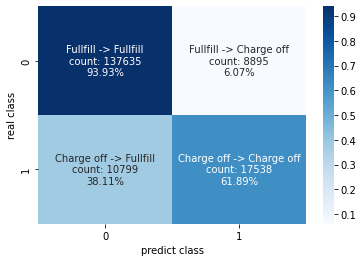

ROC Curve


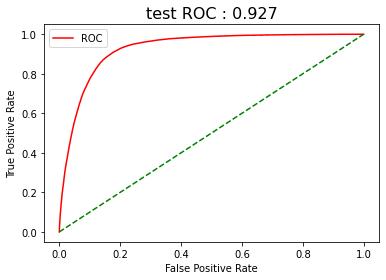

정확도: 0.8874, 정밀도: 0.6635, 재현율: 0.6189, roc_auc: 0.9274, f1: 0.6404,


In [ ]:
y_pred = BO_tuned.predict(x_test)
y_pred_proba = BO_tuned.predict_proba(x_test)[:, 1]
get_clf_eval(y_test , y_pred, y_pred_proba)

### find optimal threshold

In [ ]:
cal_df_train = pd.concat([X_train[cal_col], y_train], axis=1)
cal_df_test = pd.concat([X_test[cal_col], y_test], axis=1)
cal_df_train.head()

,funded_amnt,funded_amnt_inv,int_rate,installment,total_pymnt_inv,depvar
0,5000,5000.0,0.1144,164.74,5559.65,0.0
1,6000,6000.0,0.1899,219.91,7903.90,0.0
2,11200,11200.0,0.0689,345.27,12337.71,0.0
3,6000,6000.0,0.0818,188.52,6779.53,0.0
4,5000,5000.0,0.0975,160.75,5795.14,0.0


In [ ]:
def optimal_threshold(cal_df):
    
    def cal_tn(tpi, fai):
        return_inv = tpi- fai
        return return_inv

    def cal_fn(fa, ir, tpi):
        loss_inv = fa*(ir+1) - tpi
        return loss_inv
    
    tn_df = cal_df.loc[(cal_df["depvar"]==0)&(cal_df["y_pred"]==0)]
    fn_df = cal_df.loc[(cal_df["depvar"]==1)&(cal_df["y_pred"]==0)]

    tn_df_ = tn_df.copy()
    fn_df_ = fn_df.copy()
    tn_df_["return"] = tn_df_.apply(lambda x: cal_tn(x["total_pymnt_inv"], x["funded_amnt_inv"]), axis=1)
    fn_df_["loss"] = fn_df_.apply(lambda x: cal_fn(x["funded_amnt"], x["int_rate"], x["total_pymnt_inv"]), axis=1)
    inv_profit = tn_df_["return"].sum() - fn_df_["loss"].sum()

    return inv_profit

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

# k-fold 사용해주기 위해서 (x_train, y_train) index 다시 설정
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
cal_df_train.reset_index(drop=True, inplace=True)

weights = np.arange(1,10,1)
f = []
auc = []


for weight in weights:
    print(weight)
    max_params = {'colsample_bytree': 0.5471826123965081, 'learning_rate': 0.01937512505094028, 'n_estimators': int(840.442542764718), 'num_leaves': int(42.828443288730156),
              'reg_alpha': 0.09017363929578222, 'reg_lambda': 0.09822038009987687, 'subsample': 0.5050036453535922, 'scale_pos_weight': weight}
    cf_model = lgbm.LGBMClassifier(**max_params)
    f_score =0
    auc_score = 0

    for index, fold_index in kf.split(X=x_train, y=y_train):
        x_train_, y_train_ = x_train.iloc[fold_index], y_train[fold_index]
        cal_df_train_ = cal_df_train.iloc[fold_index]


        cf_model.fit(x_train_, y_train_)
        y_pred = cf_model.predict(x_train_)
        y_pred_proba = cf_model.predict_proba(x_train_)[:, 1]

        cal_df_train_c = cal_df_train_.copy()
        cal_df_train_c.loc[:, "y_pred"] = y_pred
        f_score +=  optimal_threshold(cal_df_train_c)/5
        auc_score += roc_auc_score(y_train_, y_pred_proba)/5

    f.append(f_score)
    auc.append(auc_score)

1
2
3
4
5
6
7
8
9


Text(0.0, 1.0, 'Train')

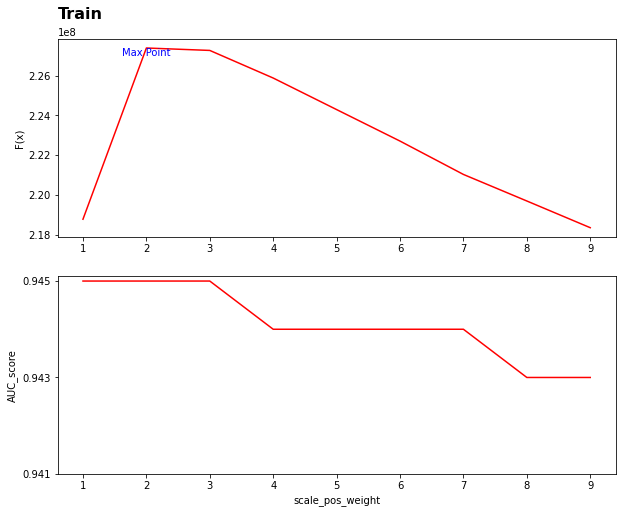

In [ ]:
plt.figure(figsize=(10, 8))			

plt.subplot(2,1,2)						
plt.plot(weights, np.round(auc, 3),'r')
plt.xlabel('scale_pos_weight')					
plt.ylabel('AUC_score')
plt.yticks(np.arange(0.941, 0.946, 0.002))	

plt.subplot(2,1,1)						
plt.plot(weights, f,'r')					
plt.ylabel('F(x)')
plt.text(2, f[1],
         'Max Point',
         color='b',
         horizontalalignment='center',
         verticalalignment='top')

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('Train', fontdict=title_font, loc='left', pad=20)

### 목적함수를 통해 구한 모델의 평가지표

오차 행렬


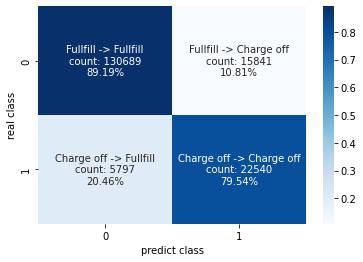

ROC Curve


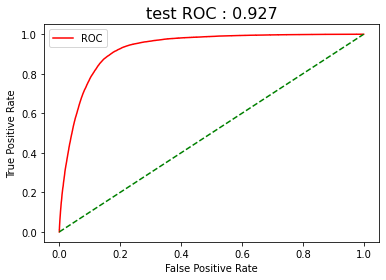

정확도: 0.8763, 정밀도: 0.5873, 재현율: 0.7954, roc_auc: 0.9274, f1: 0.6757,


In [ ]:
max_params = {'colsample_bytree': 0.5471826123965081, 'learning_rate': 0.01937512505094028, 'n_estimators': int(840.442542764718), 'num_leaves': int(42.828443288730156),
              'reg_alpha': 0.09017363929578222, 'reg_lambda': 0.09822038009987687, 'subsample': 0.5050036453535922, 'scale_pos_weight': 2}

# Bayesian Optimization의 결과를 "BO_tuend"라는 변수에 저장
BO_tuned = lgbm.LGBMClassifier(**max_params)
BO_tuned.fit(x_train, y_train)

y_pred = BO_tuned.predict(x_test)
y_pred_proba = BO_tuned.predict_proba(x_test)[:, 1]
get_clf_eval(y_test , y_pred, y_pred_proba)

### shap

In [ ]:
import shap

# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.TreeExplainer(BO_tuned)
shap_values = explainer.shap_values(x_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


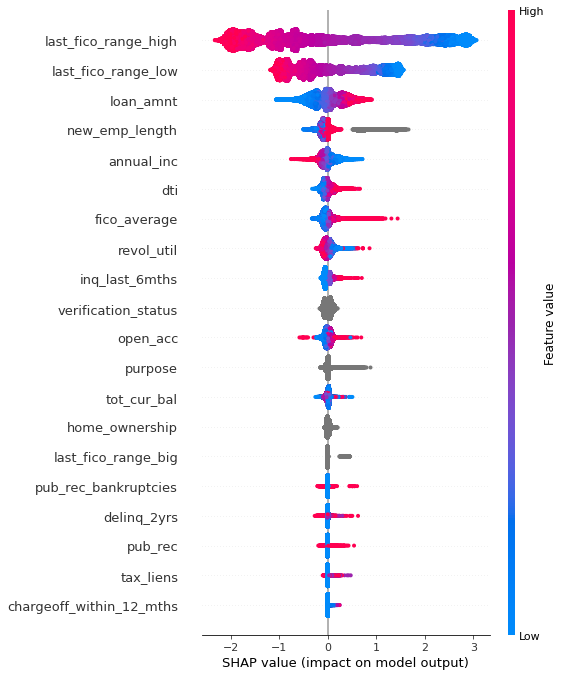

In [ ]:
# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], x_test)

open_acc 영향력 -> -0.008655794202707465
loan_amnt 영향력 -> -0.05606442539959086
new_emp_length 영향력 -> 0.0025758511763987204
chargeoff_within_12_mths 영향력 -> 0.0
fico_average 영향력 -> -0.003981117698681927
delinq_2yrs 영향력 -> 0.0
last_fico_range_low 영향력 -> 0.09164777872776374
delinq_amnt 영향력 -> -1.6594011014075971e-06
revol_util 영향력 -> 0.01273983394104184
dti 영향력 -> -0.012876436291555037
annual_inc 영향력 -> 0.02259303327877382
tax_liens 영향력 -> 0.0
tot_cur_bal 영향력 -> -0.00711844324305359
pub_rec_bankruptcies 영향력 -> 0.0
inq_last_6mths 영향력 -> -0.0008566135290851487
acc_now_delinq 영향력 -> 0.0
last_fico_range_high 영향력 -> 0.1013794251513868
pub_rec 영향력 -> 0.0


<AxesSubplot:xlabel='eff', ylabel='name'>

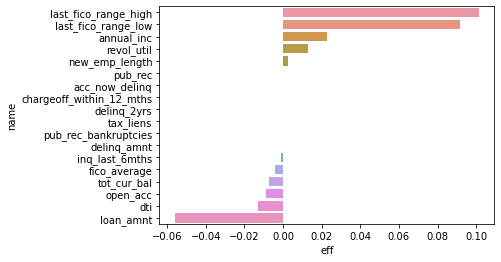

In [ ]:
og_proba_pred = BO_tuned.predict_proba(x_test)[:,1]
numerical_feats = set(x_test.columns)-set(["verification_status", "purpose", "home_ownership", "last_fico_range_big"])
ch_eff = []

for i in numerical_feats:
    te = x_test.copy()
    te.loc[:,i] = te.loc[:,i] - np.mean(x_test.loc[:,i])
    temp_proba = BO_tuned.predict_proba(te)[:,1]
    ch_eff.append((np.mean(temp_proba-og_proba_pred)))

for x,y in zip(numerical_feats,ch_eff):
    print(f'{x} 영향력 -> {y}')

coef = pd.DataFrame()
coef['name'] = pd.Series(list(numerical_feats))
coef['eff'] = pd.Series(ch_eff)

final_coef = coef.sort_values('eff',ascending=False)

sns.barplot(y ='name',x='eff',data = final_coef)

In [ ]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value[1], np.array(shap_values)[1, 1,:], x_train.iloc[1,:])

In [ ]:
y_pred[1]

1.0

In [ ]:
y_pred_proba[1]

0.7557387605065783

### OUT of sample test

In [ ]:
def new_conf(y, y_pred):
    real_pos_portion = confusion_matrix(y, y_pred)[0]/sum(confusion_matrix(y, y_pred)[0])
    real_neg_portion = confusion_matrix(y, y_pred)[1]/sum(confusion_matrix(y, y_pred)[1])
    return np.array([real_pos_portion, real_neg_portion])

def draw_cfmatrix(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    group_names = ["Fullfill -> Fullfill", "Fullfill -> Charge off", "Charge off -> Fullfill", "Charge off -> Charge off"]
    group_counts = ["count: {0:0.0f}".format(value) for value in cf_matrix.flatten()]

    #여기서 새로운 cf matrix 적용
    cf_matrix = new_conf(y, y_pred)
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    ax.set(xlabel="predict class", ylabel="real class") 
    plt.show()

def plot_roc(y, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba) 
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(y, y_pred_proba),3)),fontsize=16)
    plt.legend()
    plt.show()

def get_clf_eval(y , y_pred, y_pred_proba=None):
    confusion = confusion_matrix( y, y_pred)
    accuracy = accuracy_score(y , y_pred)
    precision = precision_score(y , y_pred)
    recall = recall_score(y , y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)

    print('오차 행렬')
    draw_cfmatrix(y , y_pred)
    print("ROC Curve")
    plot_roc(y, y_pred_proba)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, roc_auc: {3:.4f}, f1: {4:.4f},'.format(accuracy , precision ,recall, roc_auc, f1))

    return accuracy, precision, recall, roc_auc, f1

In [ ]:
oos_y.shape

(218584,)

In [ ]:
oos_x.shape

(218584, 22)

오차 행렬


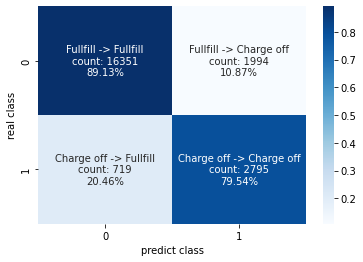

ROC Curve


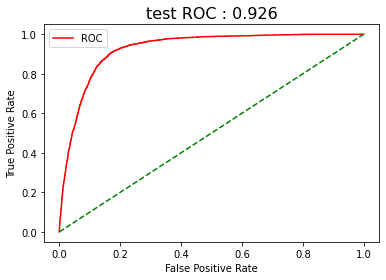

정확도: 0.8759, 정밀도: 0.5836, 재현율: 0.7954, roc_auc: 0.9258, f1: 0.6733,
오차 행렬


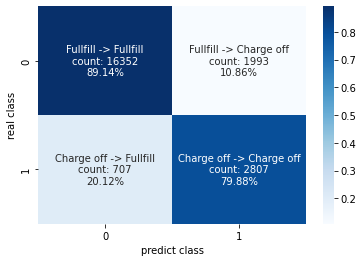

ROC Curve


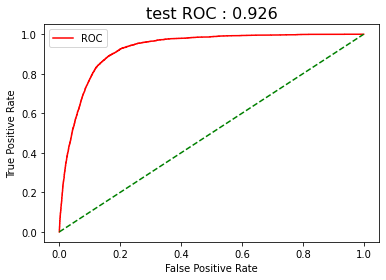

정확도: 0.8765, 정밀도: 0.5848, 재현율: 0.7988, roc_auc: 0.9264, f1: 0.6752,
오차 행렬


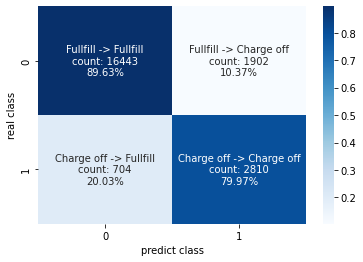

ROC Curve


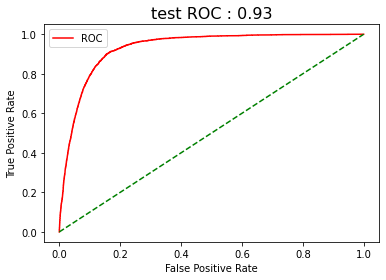

정확도: 0.8808, 정밀도: 0.5963, 재현율: 0.7997, roc_auc: 0.9304, f1: 0.6832,
오차 행렬


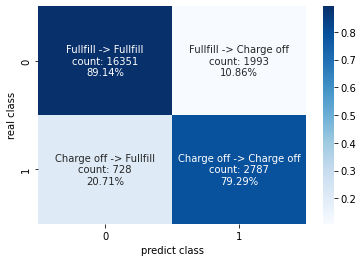

ROC Curve


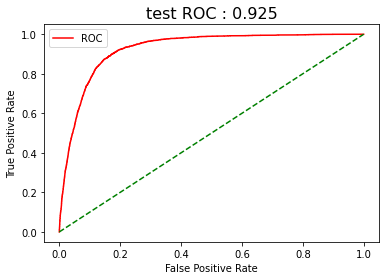

정확도: 0.8755, 정밀도: 0.5831, 재현율: 0.7929, roc_auc: 0.9253, f1: 0.6720,
오차 행렬


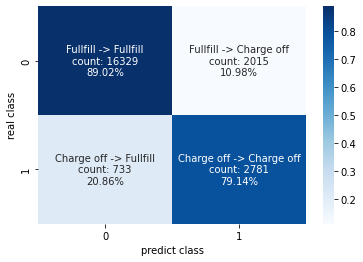

ROC Curve


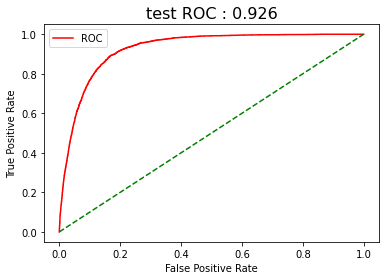

정확도: 0.8743, 정밀도: 0.5799, 재현율: 0.7914, roc_auc: 0.9264, f1: 0.6693,
오차 행렬


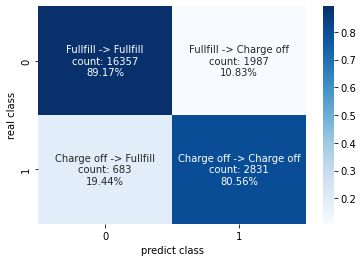

ROC Curve


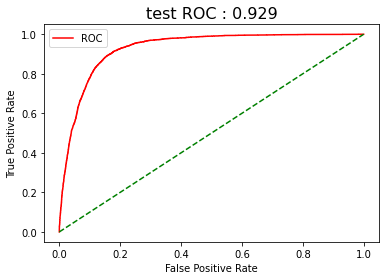

정확도: 0.8778, 정밀도: 0.5876, 재현율: 0.8056, roc_auc: 0.9288, f1: 0.6795,
오차 행렬


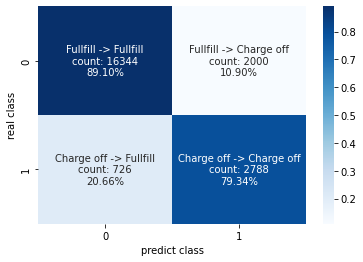

ROC Curve


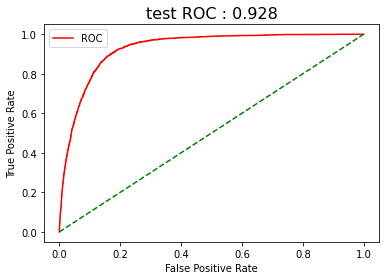

정확도: 0.8753, 정밀도: 0.5823, 재현율: 0.7934, roc_auc: 0.9280, f1: 0.6716,
오차 행렬


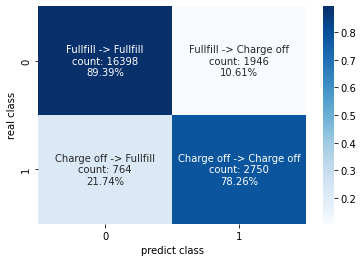

ROC Curve


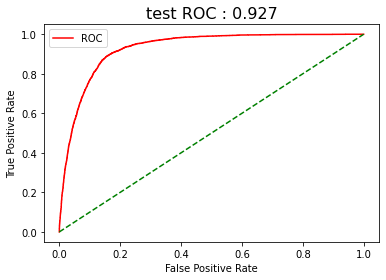

정확도: 0.8760, 정밀도: 0.5856, 재현율: 0.7826, roc_auc: 0.9274, f1: 0.6699,
오차 행렬


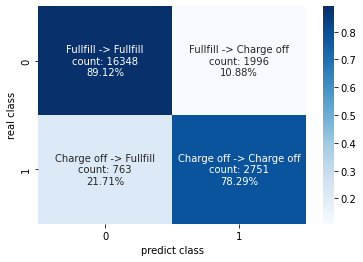

ROC Curve


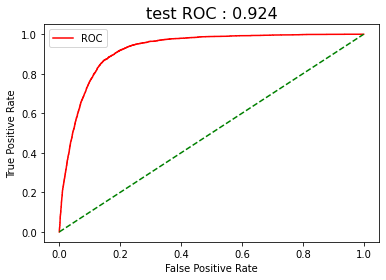

정확도: 0.8738, 정밀도: 0.5795, 재현율: 0.7829, roc_auc: 0.9236, f1: 0.6660,
오차 행렬


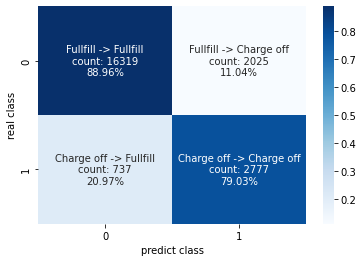

ROC Curve


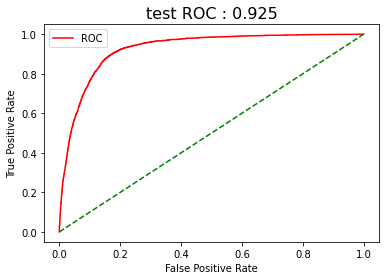

정확도: 0.8736, 정밀도: 0.5783, 재현율: 0.7903, roc_auc: 0.9249, f1: 0.6679,


In [ ]:
oos_x = test_use_df.drop(cal_col, axis=1)
oos_y = test_target_df

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2023)
accuracy_list = []
precision_list = []
recall_list = []
roc_auc_list = []
f1_list = []

for index, fold_index in kf.split(X=oos_x, y=oos_y):
    fold_x , fold_y = oos_x.iloc[fold_index], oos_y[fold_index]
    y_pred = BO_tuned.predict(fold_x)
    y_pred_proba = BO_tuned.predict_proba(fold_x)[:, 1]

    ac, pr, re, ro, f1 = get_clf_eval(fold_y, y_pred, y_pred_proba)
    accuracy_list.append(ac)
    precision_list.append(pr)
    recall_list.append(re)
    roc_auc_list.append(ro)
    f1_list.append(f1)

In [ ]:
out_of_sample_score = pd.DataFrame({"accuracy": accuracy_list,
                                    "precision": precision_list,
                                    "recall": recall_list,
                                    "Auc_score": roc_auc_list,
                                    "f1": f1_list})

out_of_sample_score = out_of_sample_score.T
out_of_sample_score.columns = ["Fold"+str(i) for i in range(1, 11)]
out_of_sample_score["Mean"] = [np.mean(out_of_sample_score.iloc[i]) for i in range(5)]
out_of_sample_score["STD"] = [np.std(out_of_sample_score.iloc[i]) for i in range(5)]

In [ ]:
out_of_sample_score

,Fold1,Fold2,Fold3,Fold4,Fold5,Fold6,Fold7,Fold8,Fold9,Fold10,Mean,STD
accuracy,0.875886,0.876481,0.880781,0.875520,0.874279,0.877848,0.875286,0.876018,0.873776,0.873639,0.875952,0.001924
precision,0.583629,0.584792,0.596350,0.583054,0.579858,0.587588,0.582289,0.585605,0.579524,0.578301,0.584099,0.004692
recall,0.795390,0.798805,0.799659,0.792888,0.791406,0.805635,0.793398,0.782584,0.782869,0.790268,0.793290,0.006494
Auc_score,0.925837,0.926407,0.930358,0.925268,0.926375,0.928754,0.927953,0.927443,0.923557,0.924884,0.926684,0.001806
f1,0.673251,0.675247,0.683200,0.671971,0.669314,0.679549,0.671645,0.669915,0.666021,0.667869,0.672798,0.004793
